In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn


In [2]:
data = pd.read_csv('AMZN.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [3]:
data = data [["Date", "Close"]]

In [4]:
data.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


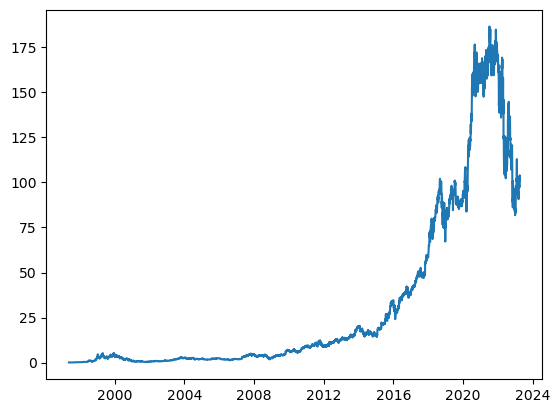

In [5]:
data["Date"] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data["Close"])
plt.show()

In [6]:
def prepare_dataset_for_lstm(data, n_steps=1):
    df = data.copy()
    df.set_index("Date", inplace=True)

    for i in range(1,n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)

    df.dropna(inplace=True)
    return df

df = prepare_dataset_for_lstm(data,7)
df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [7]:
numpy_df = df.to_numpy()
numpy_df.shape

(6509, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numpy_scaled_df = scaler.fit_transform(numpy_df)

In [9]:
y = numpy_scaled_df[:, 0]
x = numpy_scaled_df[:, 1:]
x.shape,y.shape

((6509, 7), (6509,))

In [10]:
x = np.flip(x, axis=1)

In [11]:
n = int(len(x) * 0.95)


x_train, x_test = x[:n], x[n:]
y_train, y_test = y[:n], y[n:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6183, 7), (6183,), (326, 7), (326,))

In [38]:
x_train,x_test = x_train.reshape(-1, 7, 1), x_test.reshape(-1, 7, 1)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([326, 1]))

In [39]:
x_train = torch.from_numpy(x_train.copy()).float()
y_train = torch.from_numpy(y_train.copy()).float()
x_test = torch.from_numpy(x_test.copy()).float()
y_test = torch.from_numpy(y_test.copy()).float()


AttributeError: 'Tensor' object has no attribute 'copy'

In [14]:
torch.cuda.is_available()

True

In [40]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = StockDataset(x_train, y_train)
test_dataset = StockDataset(x_test, y_test)


tensor([[0.9442],
        [0.9335],
        [0.9230],
        [0.9088],
        [0.9063],
        [0.9289],
        [0.9051]])

In [47]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
for x,y in test_loader:
    print(x.shape, y.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [49]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        out,_ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [50]:
model = LSTMModel(1,4,1)
model


LSTMModel(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [51]:
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
            

In [52]:
def validate_one_epoch(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs
            labels = labels
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [53]:
learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(model, train_loader, optimizer, loss_fn)
    validate_one_epoch(model, test_loader, loss_fn)
    
    



Epoch: 1/10, Loss: 0.049049828201532364
Epoch: 1/10, Loss: 0.06586150079965591
Epoch: 1/10, Loss: 0.07435621321201324
Epoch: 1/10, Loss: 0.00013403561024460942
Epoch: 2/10, Loss: 0.0002567579213064164
Epoch: 2/10, Loss: 0.0006367152673192322
Epoch: 2/10, Loss: 0.00015693280147388577
Epoch: 2/10, Loss: 0.00018418795662000775
Epoch: 3/10, Loss: 0.0003253564063925296
Epoch: 3/10, Loss: 0.00034708870225585997
Epoch: 3/10, Loss: 0.00012211804278194904
Epoch: 3/10, Loss: 0.00017539811960887164
Epoch: 4/10, Loss: 0.00017968163592740893
Epoch: 4/10, Loss: 8.042525587370619e-05
Epoch: 4/10, Loss: 7.653891225345433e-05
Epoch: 4/10, Loss: 0.0001386385556543246
Epoch: 5/10, Loss: 0.0001339143345830962
Epoch: 5/10, Loss: 8.331360731972381e-05
Epoch: 5/10, Loss: 0.00022378878202289343
Epoch: 5/10, Loss: 6.728521111654118e-05
Epoch: 6/10, Loss: 4.199038812657818e-05
Epoch: 6/10, Loss: 6.973740528337657e-05
Epoch: 6/10, Loss: 0.00014043526607565582
Epoch: 6/10, Loss: 3.093497798545286e-05
Epoch: 7/10,

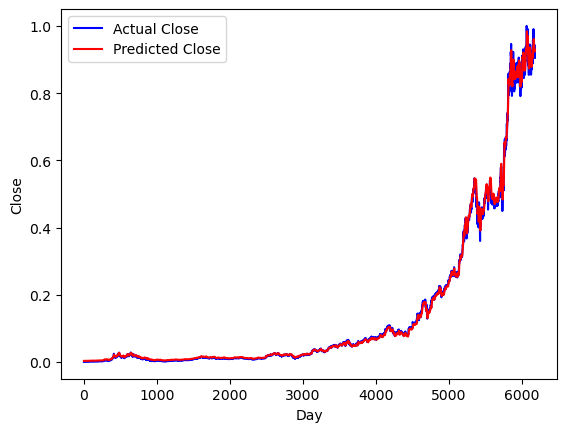

In [54]:
with torch.no_grad():
    predicted = model(x_train).cpu().numpy()

plt.plot(y_train, color='blue', label='Actual Close')
plt.plot(predicted, color='red', label='Predicted Close')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()


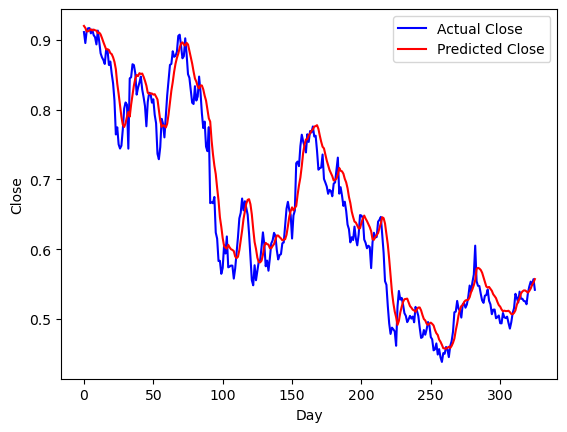

In [55]:
with torch.no_grad():
    predicted = model(x_test).cpu().numpy()

plt.plot(y_test, color='blue', label='Actual Close')
plt.plot(predicted, color='red', label='Predicted Close')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close')
plt.show()
